<a href="https://colab.research.google.com/github/harshitharavi26/PP1/blob/main/resnet_diseased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2    
from tqdm import tqdm
import random as random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
imagedetails = []
imagelabels = []
IMG_SIZE=150
diseased_dir='/content/drive/My Drive/diseased_chicken/Diseased'
healthy_dir = '/content/drive/My Drive/diseased_chicken/Healthy'

In [4]:
def read_image(label,DIR):
    
    for img in tqdm(os.listdir(DIR)):
    #for img in DIR:
        path = os.path.join(DIR,img)
        #checking image type
        _, ftype = os.path.splitext(path)
        image = cv2.imread(path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_AREA)
        imagedetails.append(np.array(image))
        imagelabels.append(str(label))

read_image("Diseased",diseased_dir)
read_image("Healthy",healthy_dir)

100%|██████████| 99/99 [00:27<00:00,  3.60it/s]


In [5]:
encoder = LabelEncoder()
#converting the images into arrays which will have its intensity values
X = np.array(imagedetails)
print(X)
#divide by 255 is to make the analysis easy because each color 8 plains (2^8==256)
X = X/255
print(X)
print(imagelabels)
#transformig the image labels into integers because it easy to deal with integers compared to strings;
y = encoder.fit_transform(imagelabels)
#dividing into 3 categories
y = to_categorical(y,4)
print(y)
#np.delete(X,1)
#np.delete(X,2)
print(X.shape)
print(y.shape)

[[[[ 33  36  34]
   [ 33  36  34]
   [ 33  36  34]
   ...
   [ 32  35  33]
   [ 32  35  33]
   [ 32  35  33]]

  [[ 33  36  34]
   [ 33  36  34]
   [ 33  36  34]
   ...
   [ 32  35  33]
   [ 32  35  33]
   [ 32  35  33]]

  [[ 34  37  35]
   [ 34  37  35]
   [ 34  37  35]
   ...
   [ 32  35  33]
   [ 32  35  33]
   [ 32  35  33]]

  ...

  [[176 230 252]
   [160 215 233]
   [137 192 211]
   ...
   [ 30  33  31]
   [ 30  33  31]
   [ 30  33  31]]

  [[162 219 236]
   [167 224 235]
   [167 223 237]
   ...
   [ 30  33  31]
   [ 30  33  31]
   [ 30  33  31]]

  [[163 222 232]
   [176 234 241]
   [180 238 245]
   ...
   [ 30  33  31]
   [ 30  33  31]
   [ 30  33  31]]]


 [[[ 22  28  23]
   [ 25  30  25]
   [ 29  33  28]
   ...
   [ 42  48  37]
   [ 44  50  39]
   [ 49  55  44]]

  [[ 30  36  31]
   [ 31  36  31]
   [ 32  36  31]
   ...
   [ 44  48  37]
   [ 46  50  39]
   [ 51  55  44]]

  [[ 37  43  38]
   [ 37  42  37]
   [ 36  40  35]
   ...
   [ 45  47  37]
   [ 47  49  39]
   [ 52  54

In [6]:
#dividing the entire dataset into training data and validation data
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)
#dividing the training dataset into training and testing
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape

((127, 150, 150, 3),
 (127, 4),
 (40, 150, 150, 3),
 (40, 4),
 (32, 150, 150, 3),
 (32, 4))

In [7]:

batch_size = 64
epochs = 100
num_classes = y.shape[1]

In [8]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
aug1=ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [9]:
from tensorflow.keras.applications import ResNet152V2
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
pre_trained_model = ResNet152V2(input_shape = (150, 150, 3),include_top=False, weights='imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('conv5_block2_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

234553344/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_____________________

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [11]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [12]:
imagegen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                            rotation_range=60,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              fill_mode='reflect')
imagegen.fit(X_train)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath = 'cnn3.hdf5',monitor='val_accuracy' ,verbose = 1, save_best_only = True)
model_dropout = model.fit_generator(imagegen.flow(X_train,y_train, batch_size=64),epochs=100,verbose=2,
                          validation_data=(X_valid, y_valid),steps_per_epoch=X_train.shape[0] // 64,callbacks=[checkpoint],shuffle=True)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to cnn3.hdf5
1/1 - 11s - loss: 17.2825 - accuracy: 0.5625 - val_loss: 7.7152 - val_accuracy: 0.6250
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.62500
1/1 - 8s - loss: 7.7114 - accuracy: 0.5938 - val_loss: 22.6636 - val_accuracy: 0.4750
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.62500
1/1 - 8s - loss: 20.9988 - accuracy: 0.4688 - val_loss: 14.5043 - val_accuracy: 0.4750
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.62500 to 0.80000, saving model to cnn3.hdf5
1/1 - 12s - loss: 10.0391 - accuracy: 0.5469 - val_loss: 3.4509 - val_accuracy: 0.8000
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.80000
1/1 - 8s - loss: 3.7291 - accuracy: 0.7812 - val_loss: 4.3411 - val_accuracy: 0.7500
Epoch 6/100

Epoch 00006: val_accuracy did not improve from 0.80000
1/1 - 8s - loss: 6.7168 - accuracy: 0.6667 - val_loss: 5.4119 - val_accuracy: 0.6500
Epoch 7/100

Epo

In [18]:
test_eval = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - loss: 0.8297 - accuracy: 0.9062


In [19]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_true = np.argmax(y_test,axis = 1).astype(int)

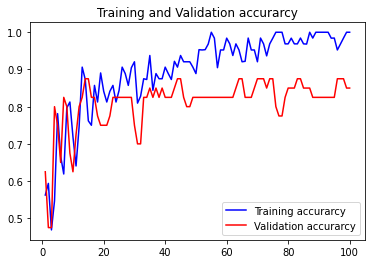

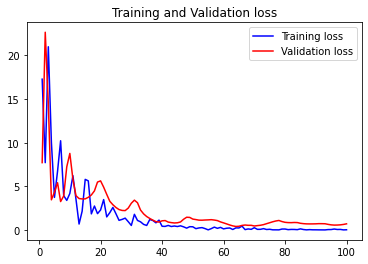

In [20]:
acc = model_dropout.history['accuracy']
val_acc = model_dropout.history['val_accuracy']
loss = model_dropout.history['loss']
val_loss = model_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [21]:
corr=[]
incorr=[]
corr_count=0
incorr_count=0

for i in range(len(y_test)):
    if(y_pred[i]==y_true[i]):
        corr.append(i)
        corr_count+=1
    else:
        incorr.append(i)
        incorr_count+=1
        
print("Found %d correct" %(corr_count))
print("Found %d incorrect " %(incorr_count))

Found 29 correct
Found 3 incorrect 


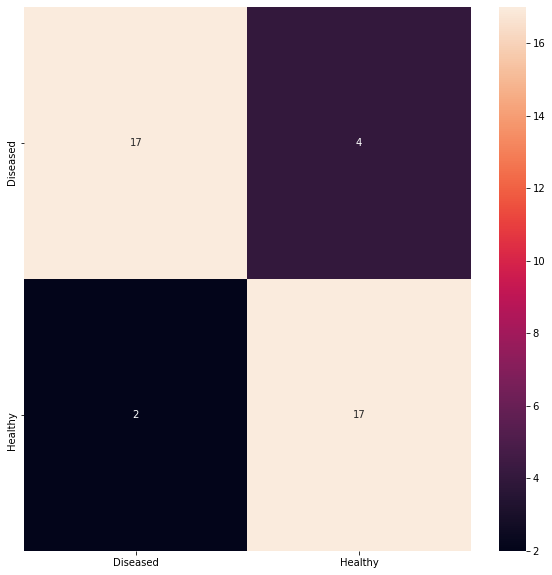

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_valid)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_valid,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()

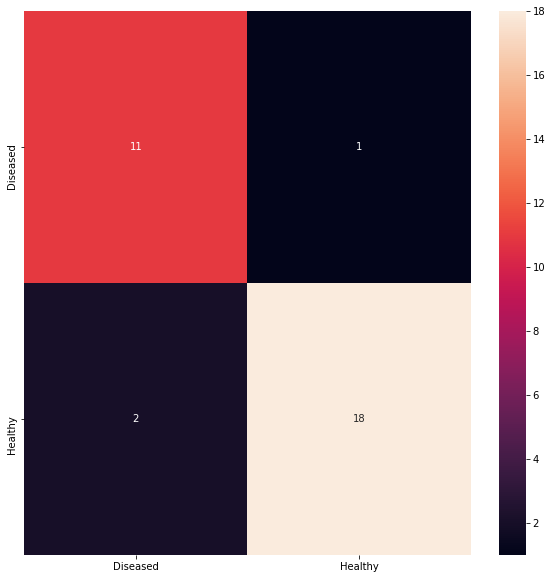

In [23]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()